# Panoram Stitching

The purpose of this notebook is to take 2 images and stitch them together to create a panorama image

#### What is SIFT ?
SIFT, or Scale Invariant Feature Transform, is a feature detection algorithm in Computer Vision.


#### Advantages of SIFT?
The major advantage of SIFT features, over edge features or hog features, is that they are not affected by the size or orientation of the image.
i.e. we can match feature over different sized images of the same thing

#### Alternatives to SIFT (2004)?
- Oriented FAST and rotated BRIEF (ORB) is a fast robust local feature detector (2011)
- SURF (Faster and less accurate alternative - 2006)


### How does SIFT work??
#### SIFT 1.) Constructing a Scale Space: To make sure that features are scale-independent
- We use the Gaussian Blurring technique to reduce the noise in an image.
- How do we ensure that these features are not be scale-dependent?
- Created images of multiple scales (often represented by σ) and used Gaussian blur for each of them to reduce the noise in the image
- Using these images, we enhance the features using a technique called Difference of Gaussians or DoG (subtraction of one blurred version of an original image from another)

Image scaling and smoothing to ensure Scale-Invariance:

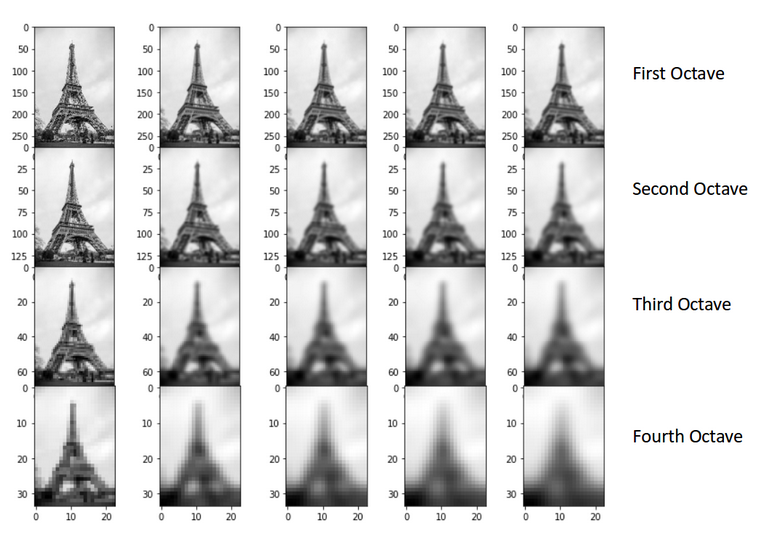

Difference of Gradients for feature extraction:

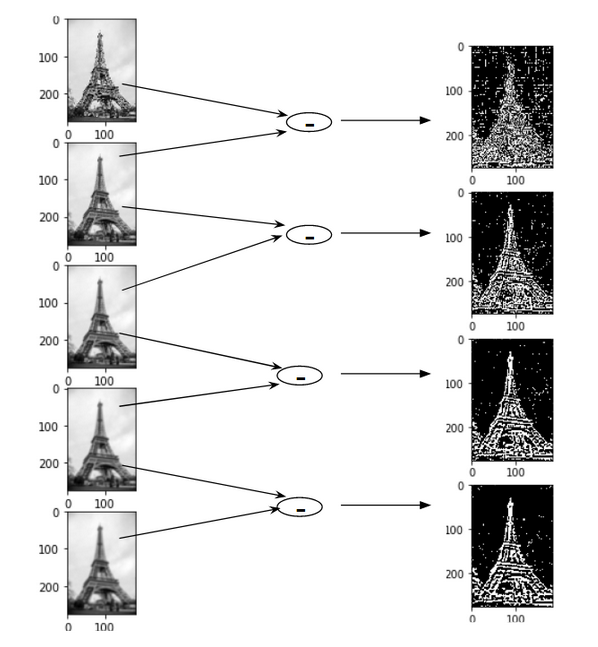

#### SIFT 2.) Keypoint Localisation: Identifying the suitable features or keypoints
- Find the local maxima and minima for the images
    - Every pixel value is compared with 26 other pixel values (some from previous (9) + next octave (9) + 8 surrounding pixels == 26 pixels total)
- Remove low contrast and near edge keypoints (keypoint selection)

#### SIFT 3.) Orientation Assignment: Ensure the keypoints are rotation invariant
- Calculate the magnitude and orientation of pixels
    - Using gradients of the pixels
- Create a histogram for magnitude and orientation
    - The bin within the histograms at which we see the peak will be the orientation for the keypoint

#### 4. Keypoint Descriptor: Assign a unique fingerprint to each keypoint
- We use the neighboring pixels, their orientations, and magnitude, to generate a unique fingerprint for this keypoint called a ‘descriptor’.
- We first take a 16×16 neighborhood around the keypoint. This 16×16 block is further divided into 4×4 sub-blocks and for each of these sub-blocks, we generate the histogram using magnitude and orientation.
- This leaves us with a bin values of 128 for every keypoint.

**Finally, we can use these keypoints for feature matching!**

<br>

In [1]:
# Imports
%config Completer.use_jedi = False  # Enables auto complete
%load_ext autoreload
%autoreload 2

import os
import sys
# sys.path.append("../")

import numpy as np
import seaborn as sns

from scipy import ndimage
import imageio
import cv2 as cv2
import matplotlib.pyplot as plt

import random
from tqdm import tqdm

from cv_utils import load_image, save_image
from cv_kernels import GAUSS_kernel, SOBEL_X, SOBEL_Y

In [2]:

def convolve(img: np.array, kernel: np.array):
    """
    Convolve function for odd dimensions.
    IT CONVOLVES IMAGES
    """
    if kernel.shape[0] % 2 != 1 or kernel.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")

    img_height = img.shape[0]
    img_width = img.shape[1]
    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    
    pad = ((pad_height, pad_height), (pad_height, pad_width))
    g = np.empty(img.shape, dtype=np.float64)
    img = np.pad(img, pad, mode='constant', constant_values=0)
    
    # Apply convolution
    for i in np.arange(pad_height, img_height+pad_height):
        for j in np.arange(pad_width, img_width+pad_width):
            roi = img[i - pad_height:i + pad_height +1, j - pad_width:j + pad_width + 1]
            g[i - pad_height, j - pad_width] = (roi*kernel).sum()

    if (g.dtype == np.float64):
        kernel = kernel / 255.0
        kernel = (kernel*255).astype(np.uint8)
    else:
        g = g + abs(np.amin(g))
        g = g / np.amax(g)
        g = (g*255.0)
    return g


def apply_non_max_suppression(image: np.array, kernel_size: int):
    #
    dX, dY = kernel_size, kernel_size
    M, N = image.shape
    for x in range(0,M-dX+1):
        for y in range(0,N-dY+1):
            window = image[x:x+dX, y:y+dY]
            if np.sum(window)==0:
                localMax=0
            else:
                localMax = np.amax(window)
            maxCoord=np.unravel_index(np.argmax(window), window.shape) + np.array((x,y))
            
            #suppress everything
            image[x:x+dX, y:y+dY]=0
            
            #reset only the max
            if localMax > 0:
                image[tuple(maxCoord)] = localMax
    return image



def identify_and_draw_corners(img: np.array, harris_array: np.array, threshold: float = 0.6):
    img_cpy = img.copy() # copying image

    # find all points above threshold (nonmax supression line)
    harris_detected_corners = np.where(harris_array >= threshold)
    n_points = len(harris_detected_corners[0])


    # drawing filtered points
    for pt in zip(*harris_detected_corners[::-1]):
        cv2.circle(img_cpy, pt, 1, (0, 0, 255), -1)

    return img_cpy, harris_detected_corners


def extract_normalized_harris_array(img: np.array, k: float = 0.06):
    img_cpy = img.copy() # copying image

    img1_gray = cv2.cvtColor(img_cpy, cv2.COLOR_BGR2GRAY) # grayscaling (0-1)

    img_dx = convolve(img1_gray, SOBEL_X) # convolving with sobel filter on X-axis
    img_dy = convolve(img1_gray, SOBEL_Y) # convolving with sobel filter on Y-axis

    # Square of derivatives
    img_dx2 = np.square(img_dx)
    img_dy2 = np.square(img_dy)
    img_dxdy = img_dx*img_dy #cross filtering
    
    # Gauss filter for all directions (x,y,cross axis)
    img_guass_g_dx2 = convolve(img_dx2, GAUSS_kernel)
    img_guass_g_dy2 = convolve(img_dy2, GAUSS_kernel)
    img_guass_g_dxdy = convolve(img_dxdy, GAUSS_kernel)
    
    # Calculate Harris Function
    # r(harris) = det - k*(trace**2)
    harris_array = (img_guass_g_dx2 * img_guass_g_dy2) - np.square(img_guass_g_dxdy) - k*np.square(img_guass_g_dx2 + img_guass_g_dy2) 
    
    # Normalizing inside (0-1) inplace
    harris_array_norm = cv2.normalize(harris_array, harris_array, 0, 1, cv2.NORM_MINMAX)
    
    return harris_array_norm, img_dx, img_dy


def detect_and_draw_harris_corners(img: np.array, sigma: float = 2, threshold_pch: float = 0.99, suppression_kernel_size: int = 3, verbose: bool = False):
    harris_map, img_dx, img_dy = extract_normalized_harris_array(img)
    if verbose:
        fig, ax = plt.subplots(1,1, figsize=(10, 8))
        sns.distplot(np.squeeze(harris_map))
        ax.axvline(x=threshold_pch, color="red")
        ax.set_title(f"Dist plot of normalised harris values of pixels within image")
        plt.show()
    
    threshold = harris_map.max() * threshold_pch
    harris_img, harris_detected_corners_initial_arr = identify_and_draw_corners(img, harris_map, threshold=threshold)
    
    if verbose:
        fig, ax = plt.subplots(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(harris_img, cv2.COLOR_BGR2RGB))
        n_points = len(harris_detected_corners_initial_arr[0])
        ax.set_title(f"Initial Harris Corner Detection: Found {n_points} corners in image")

        plt.show()

    # Now apply non-max suppresion perpendicular to edge
    harris_map_non_max_sup = apply_non_max_suppression(harris_map, kernel_size=suppression_kernel_size)
    suppress_threshold = harris_map_non_max_sup.max() * threshold_pch

    harris_detected_corner_img, harris_detected_corners_final_arr = identify_and_draw_corners(img, harris_map_non_max_sup, threshold=suppress_threshold)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    n_points = len(harris_detected_corners_final_arr[0])
    ax.set_title(f"Harris Corner Detection (After non-max-supression): Found {n_points} corners in image")
    plt.imshow(cv2.cvtColor(harris_detected_corner_img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return harris_detected_corner_img

## Load in 2 images

Found image with shape: (388, 517, 3)
Found image with shape: (388, 517, 3)


Text(0.5, 1.0, 'Image B')

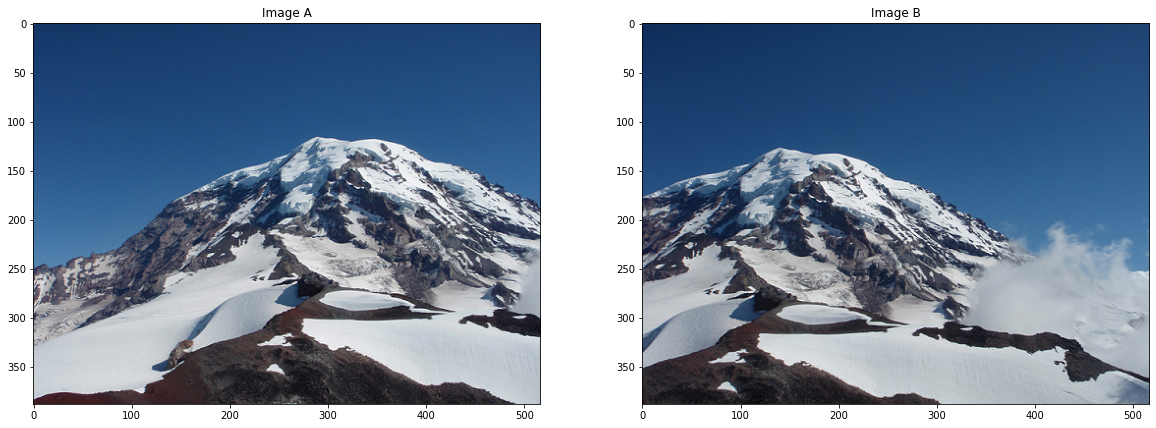

In [3]:
working_dir = "inputs"
mountain_image_file_1 = os.path.join(working_dir, "Rainier1.png")
mountain_image_file_2 = os.path.join(working_dir, "Rainier2.png")


mountain_a = load_image(mountain_image_file_1)
mountain_b = load_image(mountain_image_file_2)

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(mountain_a, cv2.COLOR_BGR2RGB))
axs[0].set_title("Image A")
axs[1].imshow(cv2.cvtColor(mountain_b, cv2.COLOR_BGR2RGB))
axs[1].set_title("Image B")

Found image with shape: (388, 517, 3)


/home/ryan/.pyenv/versions/3.9.5/envs/computer-vision-cse-455-3.9.5/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


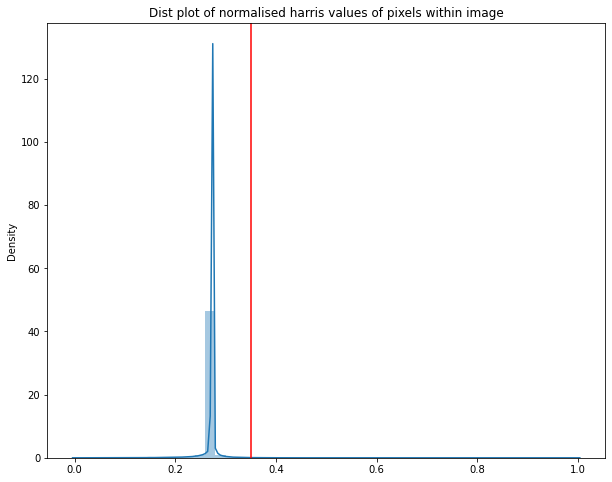

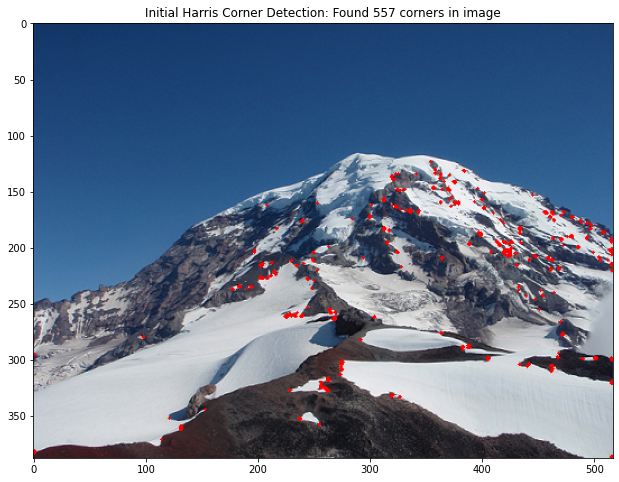

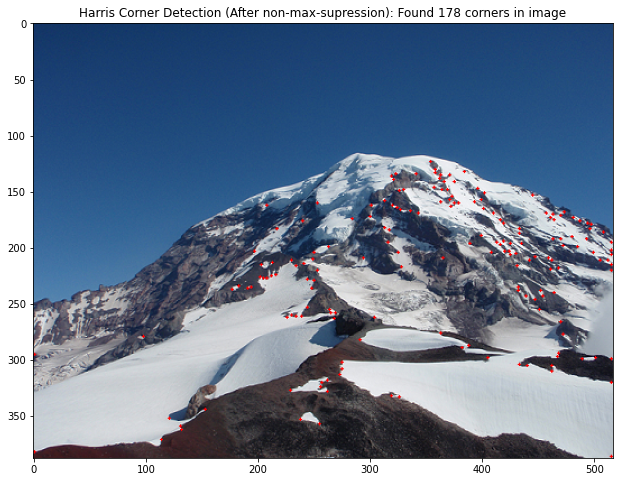

In [4]:
# Constants
harris_threshold = 0.35

# Display harris detected corners for a single image
mountain_a = load_image(mountain_image_file_1)
mountain_a_copy = mountain_a.copy()

harris_detected_corner_img = detect_and_draw_harris_corners(mountain_a_copy, sigma=2, threshold_pch=harris_threshold, suppression_kernel_size=3, verbose=True)

In [5]:
def plot_matches_acorss_images(matches: np.array, image_a: np.array, image_b: np.array):
    image_a_copy = image_a.copy()
    image_b_copy = image_b.copy()
    
    n_matches = len(matches)
    
    concatenated_img = np.concatenate((image_a_copy, image_b_copy), axis=1)
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_aspect('equal')
    ax.imshow(cv2.cvtColor(concatenated_img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Plot of all {n_matches} inlier matched keypoints")

    # Get colours
    cmap = plt.get_cmap('hsv', n_matches)
    colours = [cmap(i) for i in range(n_matches)]
    np.random.shuffle(colours)
    # colours

    offset = concatenated_img.shape[1]/2

    for match, color in zip(matches, colours):
        # Plot LHS and RHS markers
        ax.plot(match[0], match[1], 'x', color=color)
        ax.plot(match[2] + offset, match[3], 'x', color=color)

        # Plot lines between LHS and RHS markers
        ax.plot([match[0], match[2] + offset], [match[1], match[3]], color=color, linewidth=0.3)

    plt.show()

    
def keypoint_image_matcher(key_points_1, descriptors_1, img_a, key_points_2, descriptors_2, img_b, good_match_threshold) -> np.array:
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    knn_descriptor_matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)

    # Apply ratio test
    good = []
    for m,n in knn_descriptor_matches:
        if m.distance < good_match_threshold*n.distance:
            good.append([m])

    good_matches = []
    for pair in good:
        good_matches.append(list(key_points_1[pair[0].queryIdx].pt + key_points_2[pair[0].trainIdx].pt))

    final_matches = np.array(good_matches)
    return final_matches

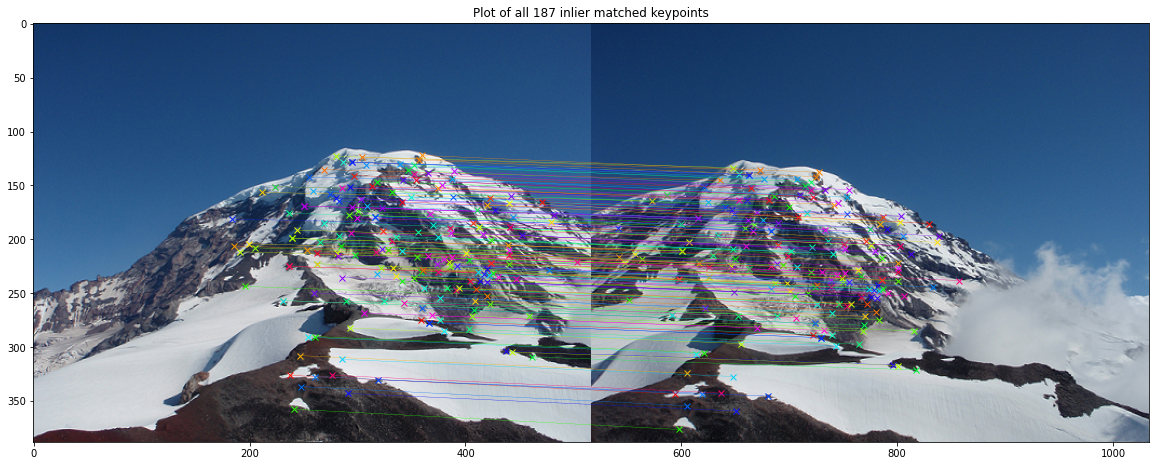

In [6]:
# Parameters
# TODO: Automate the number of inlier matched key points instead of giving a threshold?
good_match_threshold = 0.2

mountain_a_copy = mountain_a.copy()
mountain_b_copy = mountain_b.copy()

sift = cv2.SIFT_create()

# Use SIFT to compute key points and descriptors
key_points_a, descriptors_a = sift.detectAndCompute(mountain_a_copy, None)
key_points_b, descriptors_b = sift.detectAndCompute(mountain_b_copy, None)

inliers_matches = keypoint_image_matcher(key_points_a, descriptors_a, mountain_a_copy, key_points_b, descriptors_b, mountain_b_copy, good_match_threshold=good_match_threshold)
plot_matches_acorss_images(inliers_matches, mountain_a_copy, mountain_b_copy)

In [10]:

def compute_homography(pairs: np.array) -> np.array:
    rows = []
    for i in range(pairs.shape[0]):
        p1 = np.append(pairs[i][0:2], 1)
        p2 = np.append(pairs[i][2:4], 1)
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        rows.append(row1)
        rows.append(row2)
    rows = np.array(rows)
    U, s, V = np.linalg.svd(rows)
    H = V[-1].reshape(3, 3)
    # standardize to let w*H[2,2] = 1
    H = H/H[2, 2] 
    return H

def get_random_point(matches: np.array, k:int = 4) -> np.array:
    idx = random.sample(range(len(matches)), k)
    point = [matches[i] for i in idx ]
    return np.array(point)


def get_error(points: np.array, H: np.array) -> np.array:
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])
        estimate_p2[i] = (temp/temp[2])[0:2] # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2 , axis=1) ** 2

    return errors


def filter_best_inlier_matches_with_ransac(inliers_matches: np.array, ransac_threshold: float, n_iters: int):
    num_best_inliers = 0
    
    for i in range(n_iters):
        points = get_random_point(inliers_matches)
        H = compute_homography(points)
        
        #  avoid dividing by zero 
        if np.linalg.matrix_rank(H) < 3:
            continue
            
        errors = get_error(inliers_matches, H)
        idx = np.where(errors < ransac_threshold)[0]
        inliers = inliers_matches[idx]

        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H.copy()

    print(f"inliers/matches: {num_best_inliers}/{len(inliers_matches)}")
    return best_inliers, best_H


In [8]:
def stitch_two_images_with_homography(image_a: np.array, image_b: np.array, H: np.array):
    print("stiching image ...")
    
    # Convert to double and normalize. Avoid noise.
    left = cv2.normalize(image_a.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)   
    # Convert to double and normalize.
    right = cv2.normalize(image_b.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)   
    
    # left image
    left_height, left_width, left_channel = left.shape
    # height_l, width_l, channel_l = left.shape
    corners = [[0, 0, 1], [left_width, 0, 1], [left_width, left_height, 1], [0, left_height, 1]]
    corners_new = [np.dot(H, corner) for corner in corners]
    corners_new = np.array(corners_new).T 
    x_news = corners_new[0] / corners_new[2]
    y_news = corners_new[1] / corners_new[2]
    y_min = min(y_news)
    x_min = min(x_news)

    translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H = np.dot(translation_mat, H)
    
    # Get height, width
    height_new = int(round(abs(y_min) + left_height))
    width_new = int(round(abs(x_min) + left_width))
    size = (width_new, height_new)

    # right image
    left_warped = cv2.warpPerspective(src=left, M=H, dsize=size)

    right_height, right_width, right_channel = right.shape
    
    height_new = int(round(abs(y_min) + right_height))
    width_new = int(round(abs(x_min) + right_width))
    size = (width_new, height_new)

    right_warped = cv2.warpPerspective(src=right, M=translation_mat, dsize=size)
     
    # Black pixel
    black = np.zeros(3)  
    
    # Stitching procedure, store results in warped_l.
    for i in tqdm(range(right_warped.shape[0])):
        for j in range(right_warped.shape[1]):
            pixel_l = left_warped[i, j, :]
            pixel_r = right_warped[i, j, :]
            
            if not np.array_equal(pixel_l, black) and np.array_equal(pixel_r, black):
                left_warped[i, j, :] = pixel_l
            elif np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                left_warped[i, j, :] = pixel_r
            elif not np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                left_warped[i, j, :] = (pixel_l + pixel_r) / 2
            else:
                pass
                  
    stitch_image = left_warped[:right_warped.shape[0], :right_warped.shape[1], :]
    return stitch_image


def stitch_two_images_using_sift(input_image_a: np.array, input_image_b: np.array, good_match_threshold: np.array, ransac_threshold: float, n_iters: int):
    # Stage 1: ====================>
    sift = cv2.SIFT_create()

    # Use SIFT to compute key points and descriptors
    key_points_a, descriptors_a = sift.detectAndCompute(input_image_a, None)
    key_points_b, descriptors_b = sift.detectAndCompute(input_image_b, None)

    inliers_matches = keypoint_image_matcher(key_points_a, descriptors_a, input_image_a, key_points_b, descriptors_b, input_image_b, good_match_threshold=good_match_threshold)
    print(f"Number of inlier matches: {len(inliers_matches)}")

    plot_matches_acorss_images(inliers_matches, input_image_a, input_image_b) # show inliers matches
    
    # Stage 2: ====================>
    inliers, H = filter_best_inlier_matches_with_ransac(inliers_matches=inliers_matches, ransac_threshold=ransac_threshold, n_iters=n_iters)
    
    # Stitch Images with homography
    stitched_image = stitch_two_images_with_homography(input_image_a, input_image_b, H)

    # Normalise from [-1; 1] -> [0; 255]
    norm_stitched_image = cv2.normalize(stitched_image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_stitched_image = norm_stitched_image.astype(np.uint8)
    
    return norm_stitched_image
    

Found image with shape: (388, 517, 3)
Found image with shape: (388, 517, 3)
Number of inlier matches: 187


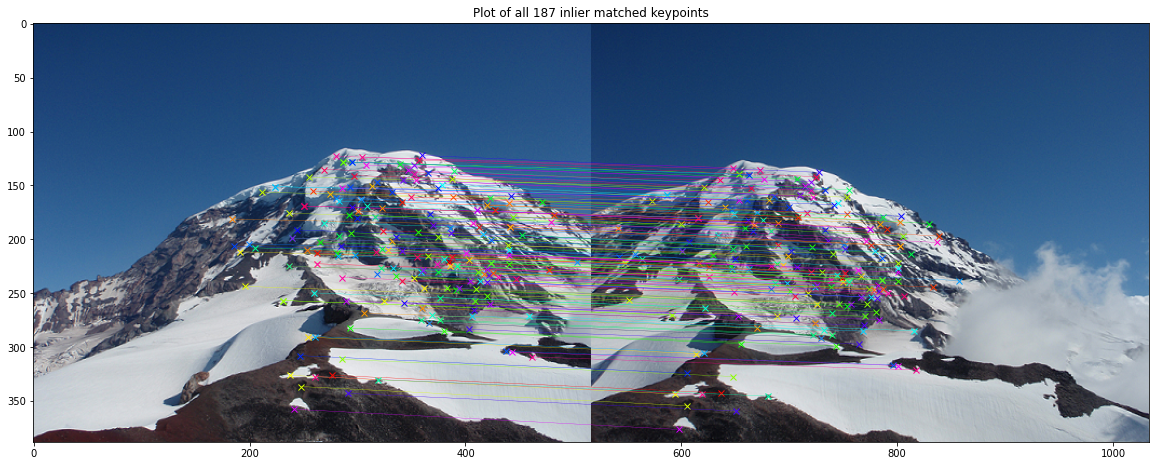

inliers/matches: 185/187
stiching image ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [00:03<00:00, 119.80it/s]


Saved pano 1 as outputs/1_pano.png


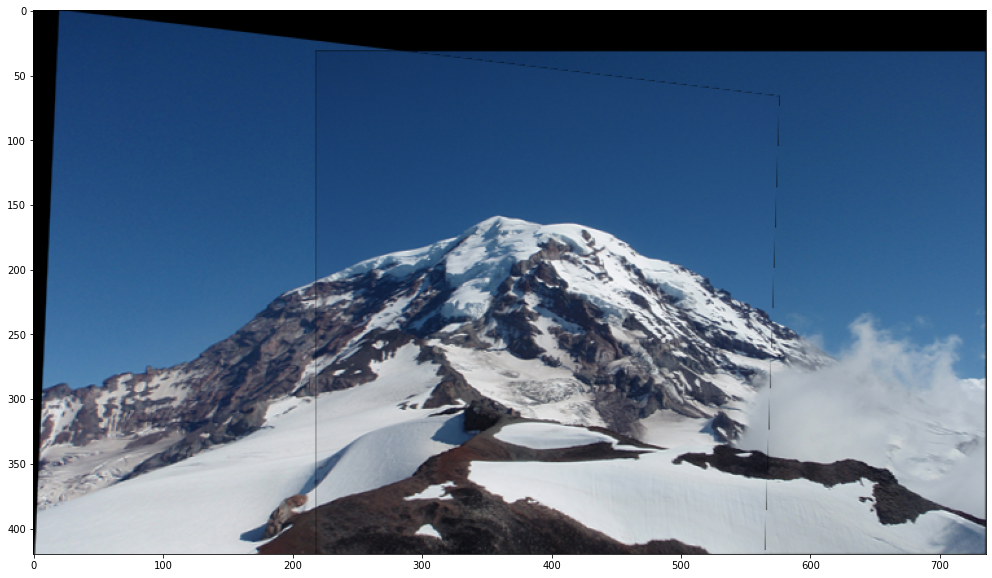

In [11]:
input_path = "inputs"
output_path = "outputs"
os.makedirs(output_path, exist_ok=True)

# Start with first image
current_image_name = "Rainier1.png"
img_names = ["Rainier2.png","Rainier3.png","Rainier4.png","Rainier5.png","Rainier6.png",]

#Load the input images
for i_img, img in enumerate(img_names[:1], 1):
    a_file_path = os.path.join(input_path, current_image_name)
    input_image_a_orig = load_image(a_file_path, display_img=False)
    
    b_file_path = os.path.join(input_path, img)
    input_image_b_orig = load_image(b_file_path, display_img=False)

    input_image_a = input_image_a_orig.copy()
    input_image_b = input_image_b_orig.copy()
    
    # Parameters
    good_match_threshold = 0.2
    ransac_threshold = 0.8
    n_iters = 500
    
    norm_stitched_image = stitch_two_images_using_sift(input_image_a, input_image_b, good_match_threshold, ransac_threshold, n_iters)
    
    # Plot image
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(norm_stitched_image, cv2.COLOR_BGR2RGB))
    
    pano_img_name = f"{i_img}_pano.png"
    pano_img_path = os.path.join(output_path, pano_img_name)
    save_image(norm_stitched_image, file_name=pano_img_path)
    print(f"Saved pano {i_img} as {pano_img_path}")
    
    # For iteration cycle
    current_image_name = pano_img_name    


**Result:**

The panorama looks good!

We can that the ridge line has been matched smoothly along mountain on the LHS and the RHS. We see that the features look good else where in the photo too

# TODO:
- Stitch Multiple images into panorama
- Write up what each function is doing mathematically with full explanations
- Add Doc strings for every function ++ Refactor with good coding principles
- Add another example of pano stitching